# Flower Recognition CNN Keras

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
print(os.listdir('/content/drive/MyDrive/flowers'))

['rose', 'sunflower', 'dandelion', 'tulip', 'daisy']


In [9]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B2, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

In [10]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/flowers/rose'


In [11]:
def assign_label(img,flower_type):
    return flower_type

In [12]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [13]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:04<00:00, 161.58it/s]

764


In [14]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:04<00:00, 170.06it/s]

1497


In [15]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:07<00:00, 132.67it/s]

2481


In [16]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:06<00:00, 169.15it/s]

3533


In [17]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:04<00:00, 166.35it/s]

4317


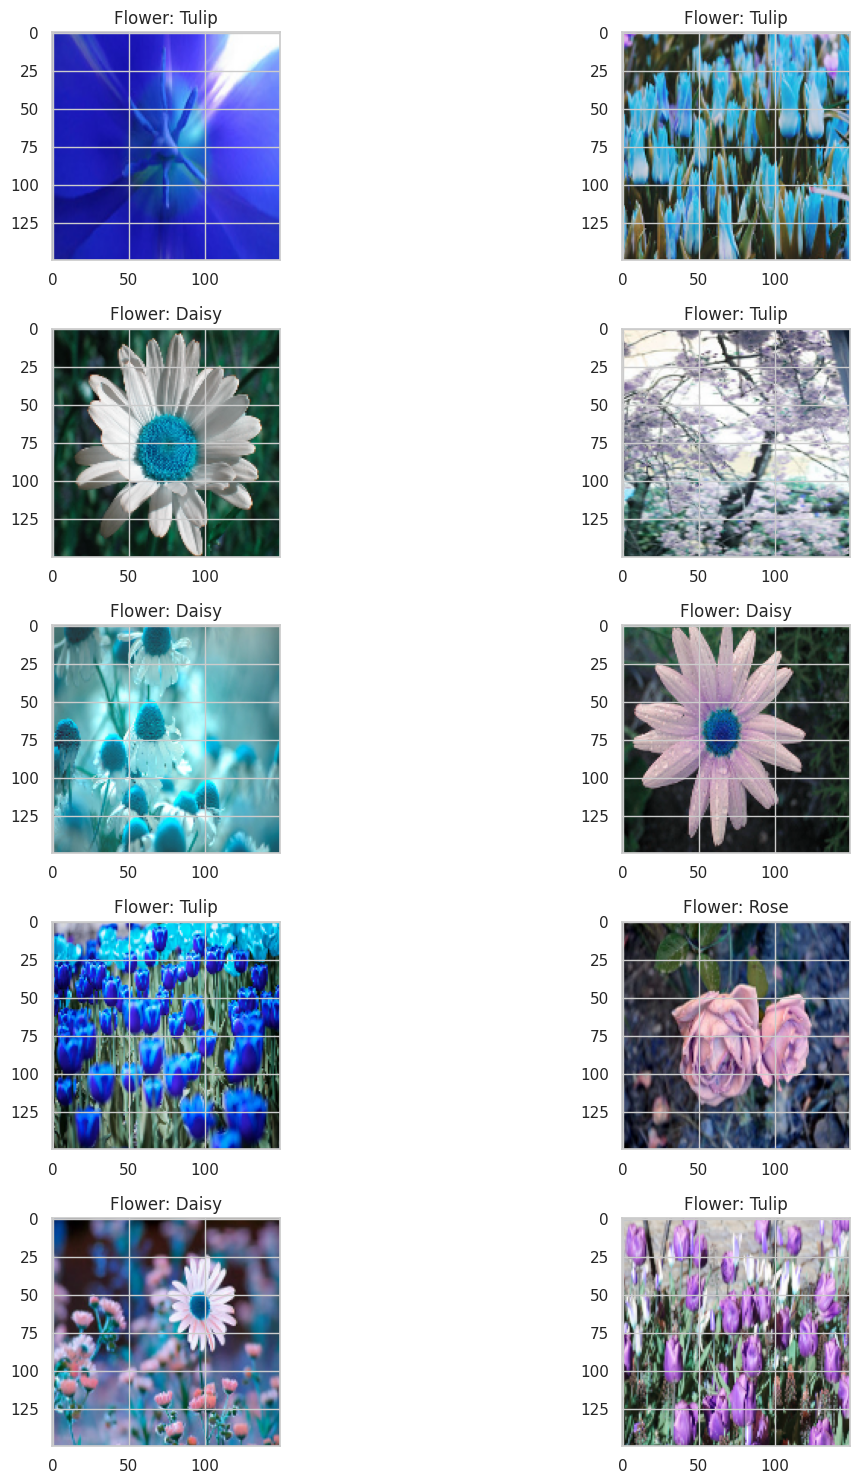

In [18]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()


In [19]:
# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding
le=LabelEncoder()
Z=le.fit_transform(Z)
Y=to_categorical(Z,5)
X=np.array(X)
X=X/255

In [20]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## Building the ConvNet Model

In [21]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [22]:
batch_size=128
epochs=25


In [23]:
#data augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [24]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

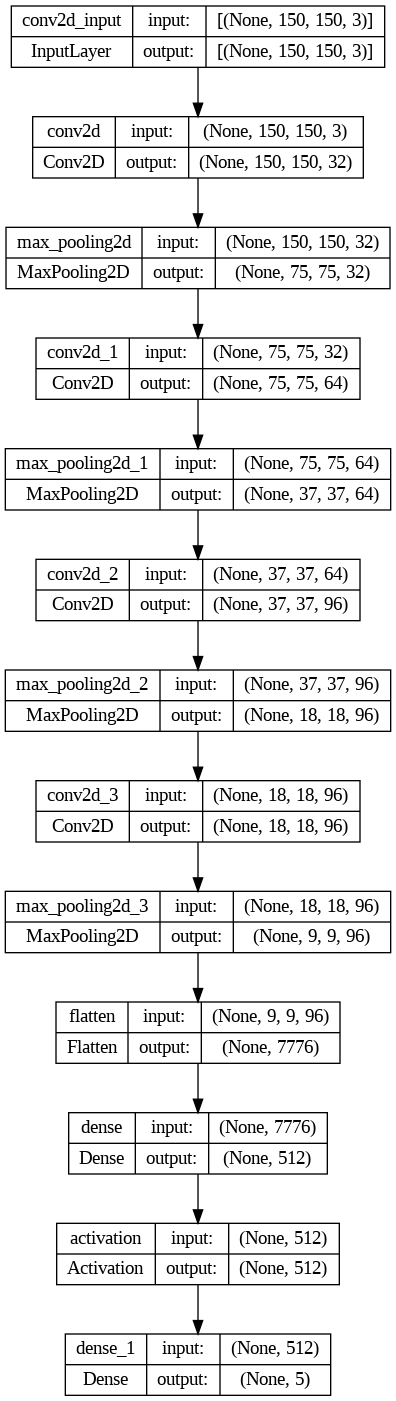

In [53]:
plot_model(model, show_shapes = True)

In [26]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/5
25/25 [==============================] - 31s 896ms/step - loss: 1.4149 - accuracy: 0.3705 - val_loss: 1.2552 - val_accuracy: 0.4546
Epoch 2/5
25/25 [==============================] - 20s 782ms/step - loss: 1.1711 - accuracy: 0.4969 - val_loss: 1.0624 - val_accuracy: 0.5620
Epoch 3/5
25/25 [==============================] - 22s 881ms/step - loss: 1.0302 - accuracy: 0.5896 - val_loss: 1.0142 - val_accuracy: 0.5917
Epoch 4/5
25/25 [==============================] - 21s 826ms/step - loss: 0.9766 - accuracy: 0.6234 - val_loss: 0.9176 - val_accuracy: 0.6250
Epoch 5/5
25/25 [==============================] - 23s 915ms/step - loss: 0.9334 - accuracy: 0.6356 - val_loss: 0.8837 - val_accuracy: 0.6537


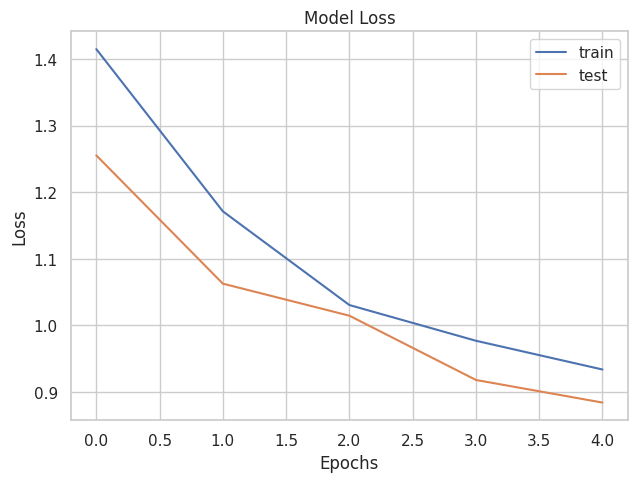

In [27]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

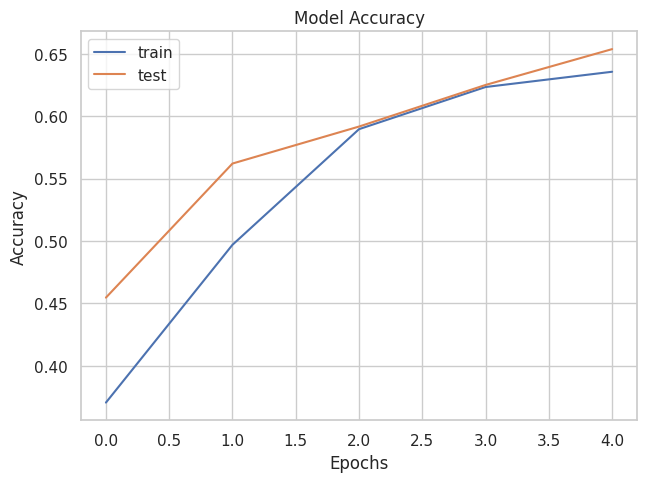

In [28]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


In [54]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_digits)
model_acc*100

34/34 [==============================] - 0s 11ms/step


65.37037037037037

In [30]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)


i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)


##ResNet50 Model

In [31]:
base_resnet50 = ResNet50(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_resnet50.layers:
    layer.trainable = False

In [32]:

inputs = Input(shape=(150, 150, 3))
x = base_resnet50(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(5, activation='softmax')(x)

model_resnet50 = Model(inputs, x)
model_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                             

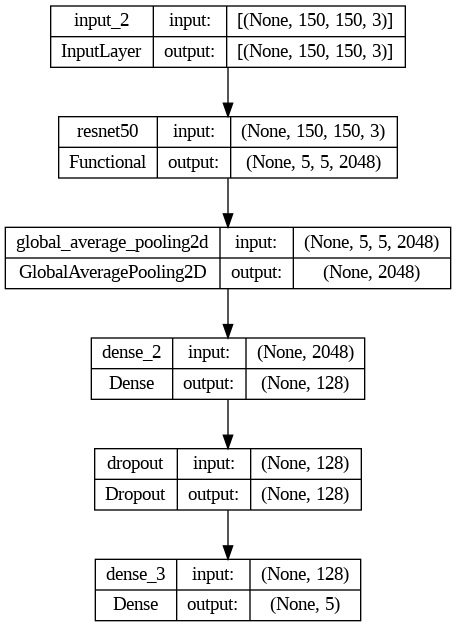

In [52]:
plot_model(model_resnet50, show_shapes = True)

In [33]:
model_resnet50.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_res50 = model_resnet50.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/5
25/25 [==============================] - 42s 1s/step - loss: 1.6051 - accuracy: 0.2599 - val_loss: 1.5576 - val_accuracy: 0.3259
Epoch 2/5
25/25 [==============================] - 31s 1s/step - loss: 1.5501 - accuracy: 0.3088 - val_loss: 1.5485 - val_accuracy: 0.3130
Epoch 3/5
25/25 [==============================] - 22s 895ms/step - loss: 1.5424 - accuracy: 0.3223 - val_loss: 1.5437 - val_accuracy: 0.3213
Epoch 4/5
25/25 [==============================] - 24s 980ms/step - loss: 1.5248 - accuracy: 0.3397 - val_loss: 1.5235 - val_accuracy: 0.3361
Epoch 5/5
25/25 [==============================] - 22s 902ms/step - loss: 1.5213 - accuracy: 0.3310 - val_loss: 1.5124 - val_accuracy: 0.3519


In [34]:
acc_rn50 = history_res50.history['accuracy']
val_acc_rn50 = history_res50.history['val_accuracy']
loss_rn50 = history_res50.history['loss']
val_loss_rn50 = history_res50.history['val_loss']

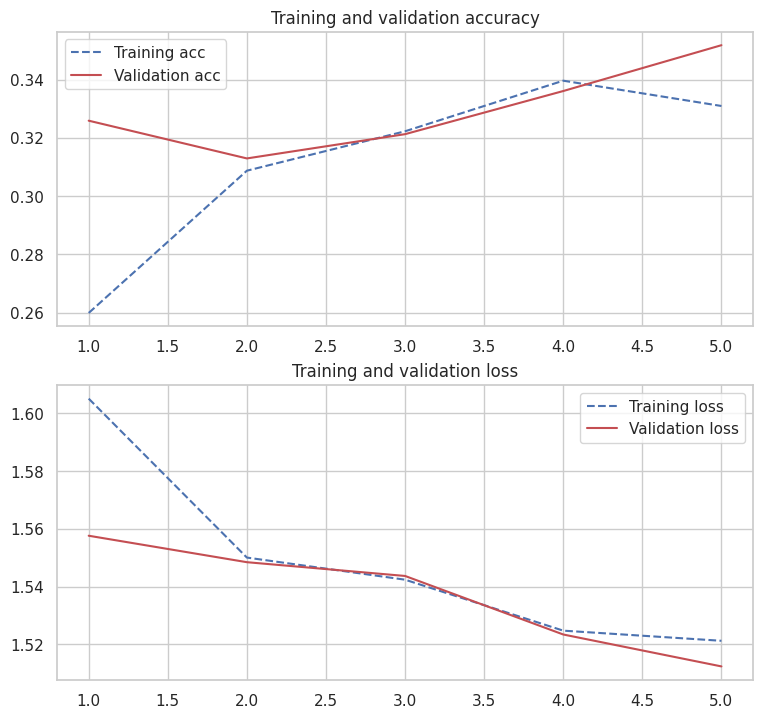

In [35]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_rn50) + 1)
ax[0].plot(epochs, acc_rn50, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_rn50, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_rn50, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_rn50, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [36]:
pred=model_resnet50.predict(x_test)
pred_res50=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

rn_acc = accuracy_score(y_classes,pred_res50)
print(rn_acc)

34/34 [==============================] - 3s 51ms/step
0.35185185185185186


##Efficient Net

In [38]:
base_effnet = EfficientNetV2B2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_effnet.layers:
    layer.trainable = False

In [39]:
inputs = Input(shape=(150, 150, 3))
x = base_effnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(5, activation='softmax')(x)

model_effnet = Model(inputs, x)
model_effnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 5, 5, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               180352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 645 

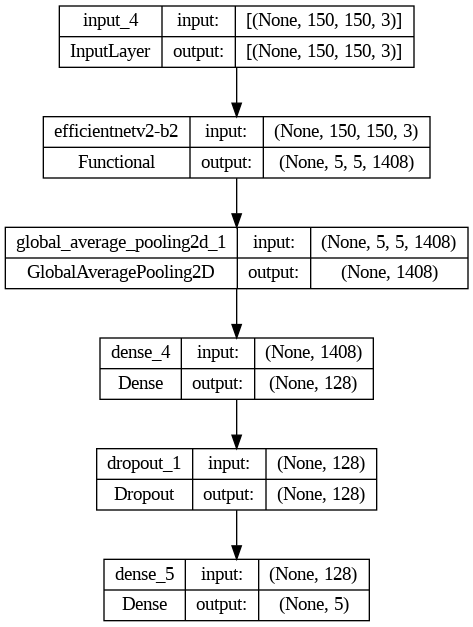

In [50]:
plot_model(model_effnet, show_shapes = True)

In [ ]:
batch_size=128
epochs=25


In [42]:
model_effnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_ef = model_effnet.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/5
25/25 [==============================] - 42s 1s/step - loss: 1.6235 - accuracy: 0.2354 - val_loss: 1.6318 - val_accuracy: 0.2491
Epoch 2/5
25/25 [==============================] - 27s 1s/step - loss: 1.5978 - accuracy: 0.2557 - val_loss: 1.6015 - val_accuracy: 0.2407
Epoch 3/5
25/25 [==============================] - 21s 825ms/step - loss: 1.5920 - accuracy: 0.2676 - val_loss: 1.5969 - val_accuracy: 0.2444
Epoch 4/5
25/25 [==============================] - 21s 828ms/step - loss: 1.5892 - accuracy: 0.2673 - val_loss: 1.5958 - val_accuracy: 0.2731
Epoch 5/5
25/25 [==============================] - 22s 877ms/step - loss: 1.5886 - accuracy: 0.2702 - val_loss: 1.5940 - val_accuracy: 0.2574


In [43]:
acc_ef = history_ef.history['accuracy']
val_acc_ef = history_ef.history['val_accuracy']
loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

In [47]:
pred=model_effnet.predict(x_test)
pred_ef=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_ef)
model_acc

34/34 [==============================] - 4s 37ms/step


0.2574074074074074

#### CORRECTLY CLASSIFIED FLOWER IMAGES

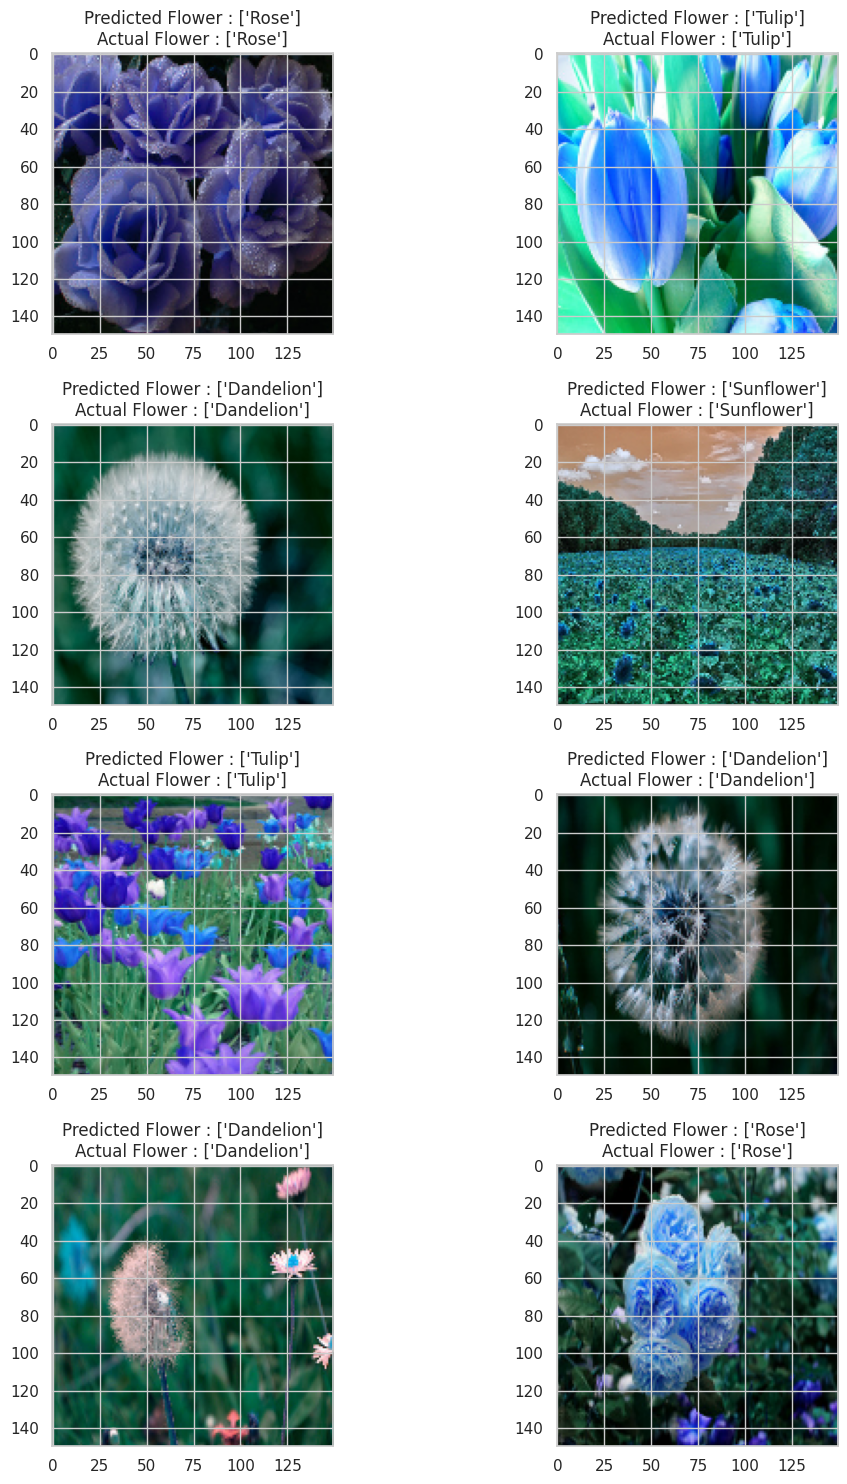

In [48]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(([y_classes[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

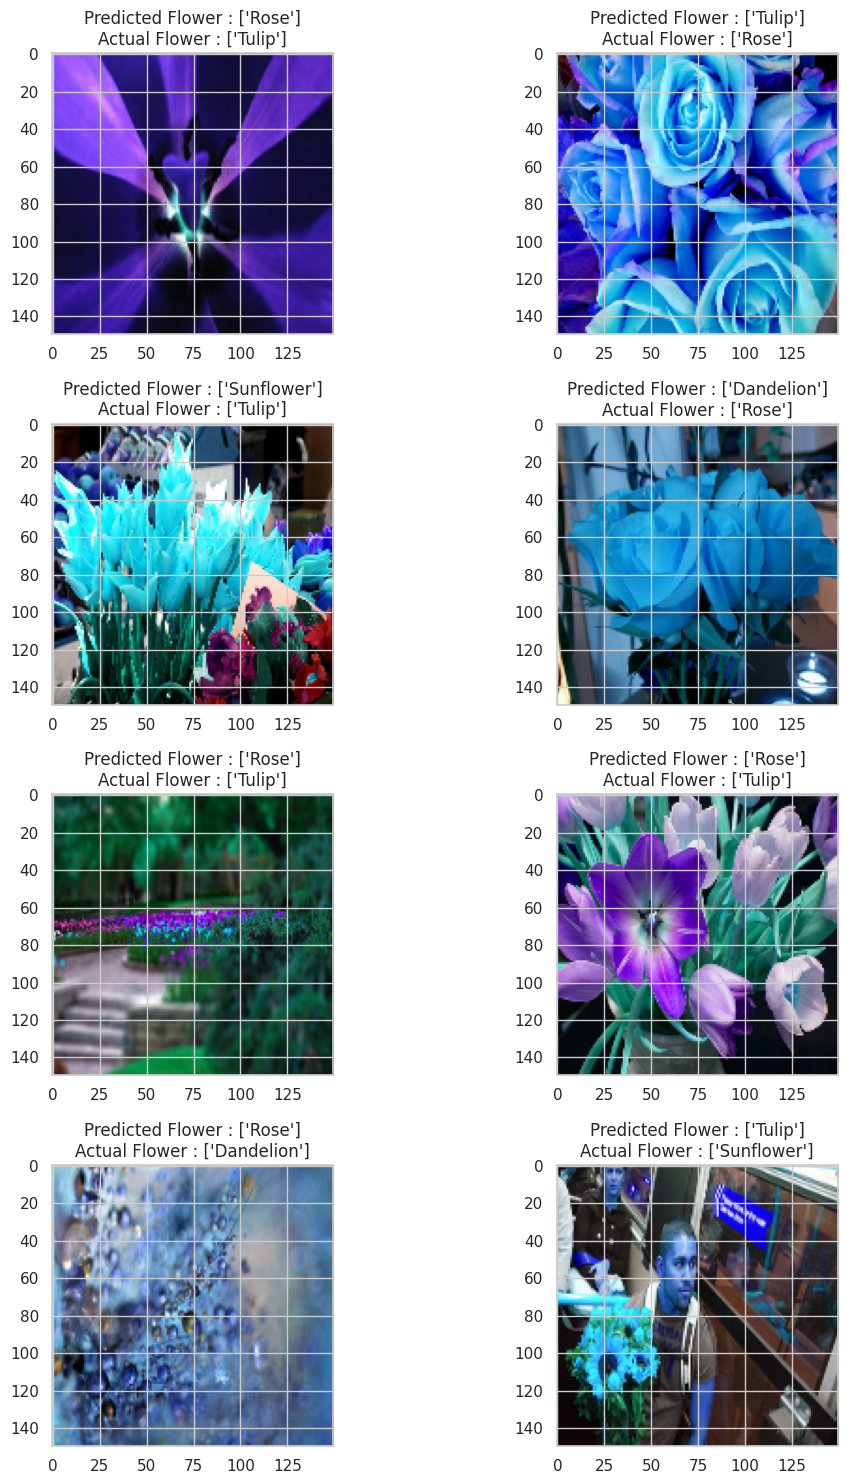

In [49]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(([y_classes[mis_class[count]]]))))
        plt.tight_layout()
        count+=1